In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import lagrange
import numpy.polynomial.polynomial as poly

from math import sqrt

---

## Interpolation Polynomials

In [2]:
def even_samples(num_points):
    return np.linspace(0,np.pi,num_points)

def ran_samples(num_points):
    return np.random.rand(num_points)*np.pi

def trig(x):
    return  2*np.cos(x)+np.sin(2*x)+np.sqrt(x)



In [3]:
x_ran = ran_samples(8)
x_even = even_samples(8)

y_ran = trig(x_ran)
y_even = trig(x_even)

In [4]:
f_even = lagrange(x_even, y_even)
f_ran = lagrange(x_ran, y_ran)

In [5]:
def La_pol(x,y,o):
    sum = 0
    for i in range(len(x)):
        prod = y[i]
        for j in range(len(x)):
            if i!=j:
                prod = prod*(o-x[j])/(x[i]-x[j])
        sum = sum + prod
    return sum

In [6]:
f_even = La_pol(x_even,y_even,np.linspace(min(x_even),max(x_even),500))
f_ran = La_pol(x_ran,y_ran,np.linspace(min(x_ran),max(x_ran),500))

#prange_even = np.linspace(min(x_even),max(x_even),500)
#prange_ran = np.linspace(min(x_ran),max(x_ran),500)

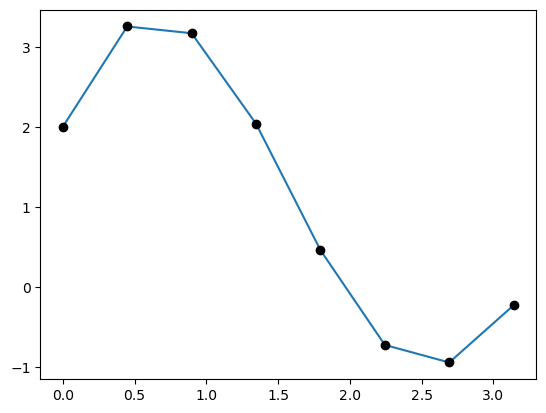

In [7]:
plt.plot(even_samples(8),La_pol(x_even,y_even,even_samples(8)))
plt.plot(x_even, y_even, 'ko')
plt.show()

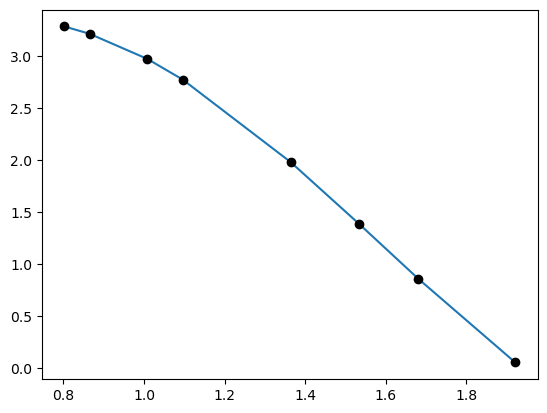

In [8]:
x = ran_samples(8)
x = np.sort(x)
y = trig(x)

plt.plot(x,La_pol(x,y,x))
plt.plot(x,y, 'ko')
plt.show()

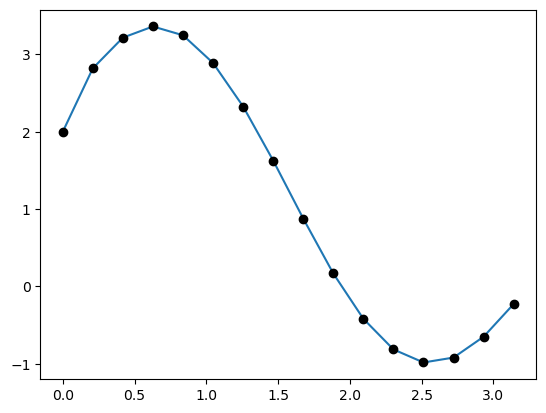

In [9]:
plt.plot(even_samples(16),La_pol(even_samples(16),trig(even_samples(16)),even_samples(16)))
plt.plot(even_samples(16),trig(even_samples(16)), 'ko')
plt.show()

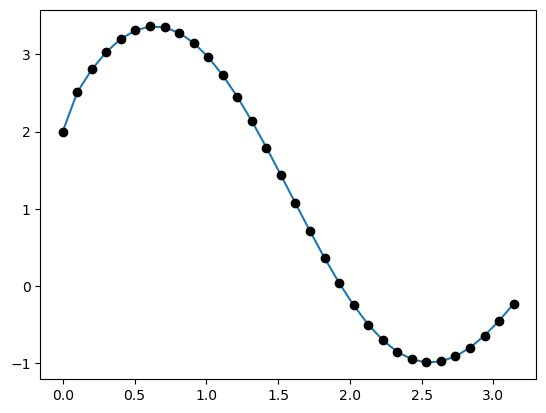

In [10]:
plt.plot(even_samples(32),La_pol(even_samples(32),trig(even_samples(32)),even_samples(32)))
plt.plot(even_samples(32),trig(even_samples(32)), 'ko')
plt.show()

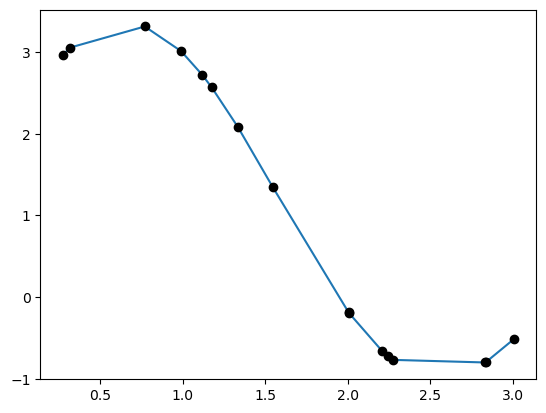

In [11]:
x = ran_samples(16)
x = np.sort(x)
y = trig(x)

plt.plot(x,La_pol(x,y,x))
plt.plot(x,y, 'ko')
plt.show()

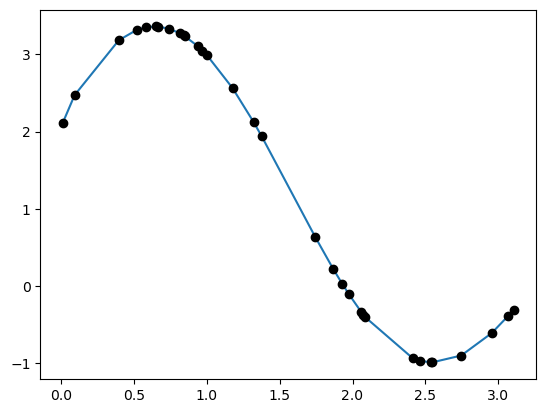

In [12]:
x = ran_samples(32)
x = np.sort(x)
y = trig(x)

plt.plot(x,La_pol(x,y,x))
plt.plot(x,y, 'ko')
plt.show()

---

## Splines

In [13]:
def cubic_interp1d(x0, x, y):
    """
    Interpolate a 1-D function using cubic splines.
      x0 : a float or an 1d-array
      x : (N,) array_like
          A 1-D array of real/complex values.
      y : (N,) array_like
          A 1-D array of real values. The length of y along the
          interpolation axis must be equal to the length of x.

    Implement a trick to generate at first step the cholesky matrice L of
    the tridiagonal matrice A (thus L is a bidiagonal matrice that
    can be solved in two distinct loops).

    additional ref: www.math.uh.edu/~jingqiu/math4364/spline.pdf
    """
    x = np.asfarray(x)
    y = np.asfarray(y)

    # remove non finite values
    # indexes = np.isfinite(x)
    # x = x[indexes]
    # y = y[indexes]

    # check if sorted
    if np.any(np.diff(x) < 0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    # allocate buffer matrices
    Li = np.empty(size)
    Li_1 = np.empty(size-1)
    z = np.empty(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = sqrt(2*xdiff[0])
    Li_1[0] = 0.0
    B0 = 0.0 # natural boundary
    z[0] = B0 / Li[0]

    for i in range(1, size-1, 1):
        Li_1[i] = xdiff[i-1] / Li[i-1]
        Li[i] = sqrt(2*(xdiff[i-1]+xdiff[i]) - Li_1[i-1] * Li_1[i-1])
        Bi = 6*(ydiff[i]/xdiff[i] - ydiff[i-1]/xdiff[i-1])
        z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    i = size - 1
    Li_1[i-1] = xdiff[-1] / Li[i-1]
    Li[i] = sqrt(2*xdiff[-1] - Li_1[i-1] * Li_1[i-1])
    Bi = 0.0 # natural boundary
    z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1]*z[i+1])/Li[i]

    # find index
    index = x.searchsorted(x0)
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
         zi1/(6*hi1)*(x0-xi0)**3 + \
         (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
         (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return f0

In [14]:
cubic_interp1d([x_even[0]],x_even,y_even)

array([2.])

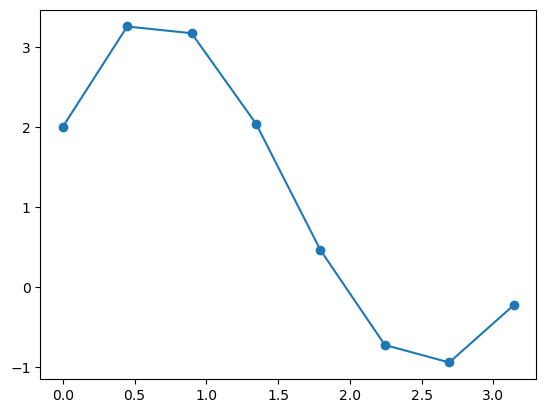

In [15]:
x = np.linspace(0, 10, 11)
y = np.sin(x)
plt.scatter(x_even, y_even)

x_new = np.linspace(0, 10, 201)
plt.plot(x_even, cubic_interp1d(x_even,x_even,y_even))

plt.show()

In [16]:
def cubic_interpolate(x0, x, y):

    xdiff = np.diff(x)
    dydx = np.diff(y)
    dydx /= xdiff

    n = size = len(x)

    w = np.empty(n-1, float)
    z = np.empty(n, float)

    w[0] = 0.
    z[0] = 0.
    for i in range(1, n-1):
        m = xdiff[i-1] * (2 - w[i-1]) + 2 * xdiff[i]
        w[i] = xdiff[i] / m
        z[i] = (6*(dydx[i] - dydx[i-1]) - xdiff[i-1]*z[i-1]) / m
    z[-1] = 0.

    for i in range(n-2, -1, -1):
        z[i] = z[i] - w[i]*z[i+1]

    # find index (it requires x0 is already sorted)
    index = x.searchsorted(x0)
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
        zi1/(6*hi1)*(x0-xi0)**3 + \
        (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
        (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return f0

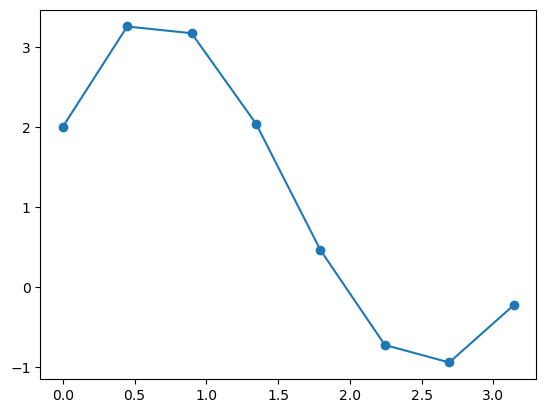

In [17]:
x = np.linspace(0, 10, 11)
y = np.sin(x)
plt.scatter(x_even, y_even)

x_new = np.linspace(0, 10, 201)
plt.plot(x_even, cubic_interpolate(x_even,x_even,y_even))

plt.show()

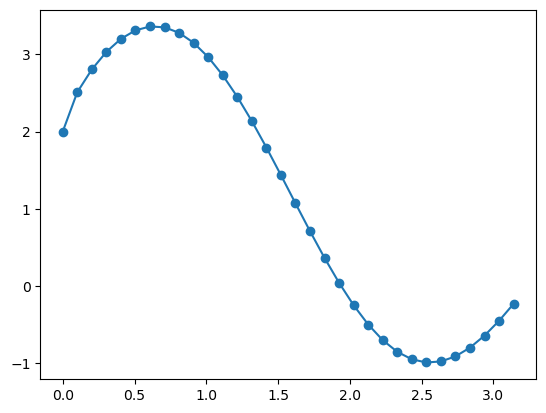

In [18]:
x = even_samples(32)
y = trig(even_samples(32))
plt.scatter(x, y)

x_new = np.linspace(0, 10, 201)
plt.plot(x, cubic_interpolate(x,x,y))

plt.show()

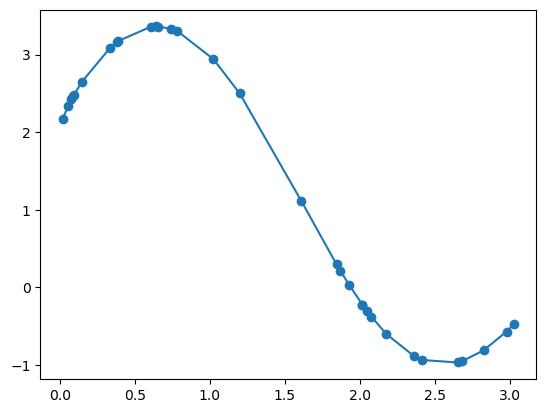

In [19]:
x = ran_samples(32)
x = np.sort(x)
y = trig(x)
plt.scatter(x, y)

x_new = np.linspace(0, 10, 201)
plt.plot(x, cubic_interpolate(x,x,y))

plt.show()

In [20]:
np.sort(x)

array([0.01842953, 0.05446599, 0.07660721, 0.08819982, 0.09317581,
       0.14672715, 0.33376567, 0.38161066, 0.38698852, 0.60483997,
       0.64288813, 0.65577264, 0.74312663, 0.78336626, 1.02359872,
       1.19804875, 1.60838232, 1.84434188, 1.86900705, 1.92897935,
       2.01710141, 2.0171702 , 2.05031919, 2.07759407, 2.17581513,
       2.36008437, 2.41626162, 2.65198377, 2.68182604, 2.82522771,
       2.97879038, 3.02596089])

---

# Least Squares

---
# XXZ Spin Model

In [21]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as plt
import seaborn as sns

from scipy import sparse
from scipy.sparse.linalg import eigsh

In [22]:

# * Storing variables for convinience
Variables = {}

## * Main Objects
Variables['sx'] = np.array( 
    [[0,1],[1,0]]
)

Variables['sz'] = np.array(
    [[1,0],[0,-1]]
)

### * Idetity Matrix
Variables['Id'] = np.identity(2)

### * Number of spins
Variables['N'] = 5

J_x = np.random.rand()

J_z = np.random.rand()

g = J_x/J_z

In [23]:

## * Main Objects
sx = np.array( 
    [[0,1],[1,0]]
)

sz = np.array(
    [[1,0],[0,-1]]
)

### * Idetity Matrix
Id = np.identity(2)

### * Number of spins
N = 50

J_x = np.random.rand()

J_z = np.random.rand()

g = J_x/J_z

In [24]:
def m_z(H, sigma_z):

    # * Eigensolver
    e_vals,e_vecs = eigsh(H)

    # * Ground state Expectation Value
    # return sum([i.T @ sigma_z @ i for i in e_vecs])/N
    return (e_vecs[0].T @ sigma_z @ e_vecs[0])/N

def H_g(g):
    
    # * Extracting varuables
    # sx = Variables['sx']
    # sz = Variables['sz']
    # Id = Variables['Id']
    # N = Variables['N']
    # J_x = Variables['J_x']
    # J_z = Variables['J_z']
    
    # * Storing elements
    spin_x = {}
    spin_z = {}

    # * x Interaction
    for i in range(1,N-1): # TODO: This can be vectorized
        spin_x[f"sx_{i},sx_{i+1}"] = np.kron(sx,sx)

    ## * Closing the chain
    spin_x[f"sx_{4},sx_{0}"] = np.kron(sx,sx)

    # * z Interaction
    for i in range(1,N-1): # TODO: This can be vectorized
        spin_z[f"sz_{i}"] = np.kron(sz,Id)

    # * Hamiltonian Contributions
    sx_cont = sum(spin_x.values())
    sz_cont = sum(spin_z.values())

    H = sx_cont + (1/g)*sz_cont

    return m_z(H, sz_cont)

def H_ginv(g):
    # * Extracting varuables
    # sx = Variables['sx']
    # sz = Variables['sz']
    # Id = Variables['Id']
    # N = Variables['N']
    # J_x = Variables['J_x']
    # J_z = Variables['J_z']
    
    # * Storing elements
    spin_x = {}
    spin_z = {}

    # * x Interaction
    for i in range(1,N-1): # TODO: This can be vectorized
        spin_x[f"sx_{i},sx_{i+1}"] = np.kron(sx,sx)

    ## * Closing the chain
    spin_x[f"sx_{4},sx_{0}"] = np.kron(sx,sx)

    # * z Interaction
    for i in range(1,N-1): # TODO: This can be vectorized
        spin_z[f"sz_{i}"] = np.kron(sz,Id)

    # * Hamiltonian Contributions
    sx_cont = sum(spin_x.values())
    sz_cont = sum(spin_z.values())

    H = g*sx_cont + sz_cont

    return m_z(H, sz_cont)


In [25]:

# * Variation of g
g_vals = np.linspace(-2,2,1000)

VEC_H_g = np.vectorize(H_g)
VEC_H_ginv = np.vectorize(H_ginv)

H_g_vals = VEC_H_g(g_vals)
H_ginv_vals = VEC_H_ginv(g_vals)

data = {
    'g_vals' : g_vals,
    'H_g_vals' : H_g_vals,
    'H_ginv_vals' : H_ginv_vals
}

df = pd.DataFrame(data)

/tmp/ipykernel_448910/2714909510.py:4: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  e_vals,e_vecs = eigsh(H)


In [26]:
df

,g_vals,H_g_vals,H_ginv_vals
0,-2.000000,0.422273,-0.422273
1,-1.995996,0.422956,-0.422956
2,-1.991992,0.423640,-0.423640
3,-1.987988,0.424327,-0.424327
4,-1.983984,0.425016,-0.425016
...,...,...,...
995,1.983984,-0.425016,-0.425016
996,1.987988,-0.424327,-0.424327
997,1.991992,-0.423640,-0.423640
998,1.995996,-0.422956,-0.422956


<Axes: xlabel='g_vals', ylabel='H_g_vals'>

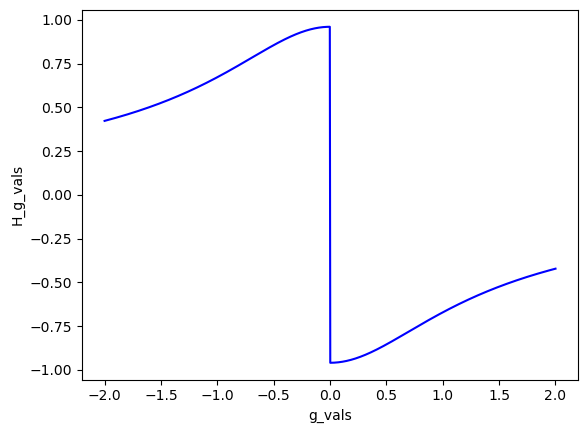

In [27]:
sns.lineplot(
    data=df,
    x='g_vals',
    y='H_g_vals',
    color='blue'
)

<Axes: xlabel='g_vals', ylabel='H_ginv_vals'>

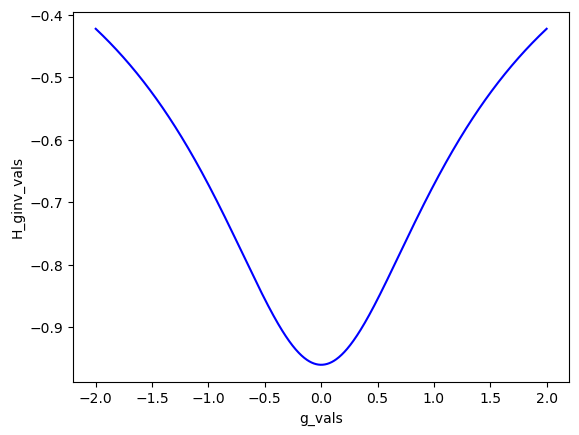

In [28]:
sns.lineplot(
    data=df,
    x='g_vals',
    y='H_ginv_vals',
    color='blue'
)

In [29]:
# TODO: Compare with exact solution

---
# Bose-Hubard Model

$H=-t\sum _{\left\langle i,j\right\rangle }\left({\hat {b}}_{i}^{\dagger }{\hat {b}}_{j}+{\hat {b}}_{j}^{\dagger }{\hat {b}}_{i}\right)+{\frac {U}{2}}\sum _{i}{\hat {n}}_{i}\left({\hat {n}}_{i}-1\right)-\mu \sum _{i}{\hat {n}}_{i}$

In [52]:

# * Main Objects

## * Number of sites
N = 7

## * Param
t = np.random.rand()
U = np.random.rand()
mu = np.random.rand()
g = t/U

# * Creation & Annihilation operators
def b_op(N):
    values = np.sqrt(np.arange(1, N))
    matrix = np.zeros((N, N))
    np.fill_diagonal(matrix[1:], values)
    return matrix

b = b_op(N)
b_dag = b.T

## * Number Operator
def n_op(b):
    return b.T @ b

n = n_op(b)

Id = np.identity(N)

In [61]:
def fluc(H, m):
    
    # * Eigensolver
    e_vals,e_vecs = eigsh(H)

    # * Computing Variance
    m2 = m @ m
    
    var = (e_vecs[0].T @ m2 @ e_vecs[0]) - (e_vecs[0].T @ m @ e_vecs[0])**2
    
    return var

def H_hb(N,g,U):
    
    # * Storing elements
    # b = b(N)
    # b_dag = b.T
    # n = n(b) 

    b_cont= {}
    n_n_cont = {}
    n_cont = {}

    # * b Interaction
    for i in range(1,N-1): # TODO: This can be vectorized
        b_cont[f"{i}{i+1}"] = np.kron(b,b_dag) + np.kron(b_dag,b)

    ## * Closing the chain
    b_cont[f"{N},{0}"] = np.kron(b,b_dag) + np.kron(b_dag,b)

    # * n(n-1) Interaction
    for i in range(1,N-1): # TODO: This can be vectorized
        n_n_cont[f"{i}"] = np.kron(Id,n) * (np.kron(Id,n) - np.kron(Id,Id))

    # * n Interaction
    for i in range(1,N-1): # TODO: This can be vectorized
        n_cont[f"{i}"] = np.kron(n,Id)

    # * Hamiltonian Contributions
    b_sum = sum(b_cont.values())
    n_n_sum = sum(n_n_cont.values())
    n_sum = sum(n_cont.values())

    H = -g*b_sum + (1/2)*n_n_sum - (mu/U)*n_sum

    e_vals,e_vecs = eigsh(H)

    return np.shape(e_vecs[0])
    # return fluc(H, n_sum)


In [62]:
H_hb(10,2,2)

(6,)

In [59]:

# * Variation of g
g_vals = np.linspace(-2,2,1000)
U_vals = t/g_vals

VEC_H_g = np.vectorize(H_hb)

H_g_vals = VEC_H_g(N,g_vals,U_vals)

data = {
    'g_vals' : g_vals,
    'H_g_vals' : H_g_vals,
}

df = pd.DataFrame(data)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 49 is different from 6)

In [ ]:
df

,g_vals,H_g_vals
0,-2.000000,9.404949
1,-1.995996,9.386120
2,-1.991992,9.367291
3,-1.987988,9.348463
4,-1.983984,9.329634
...,...,...
995,1.983984,-9.329634
996,1.987988,-9.348463
997,1.991992,-9.367291
998,1.995996,-9.386120


<Axes: xlabel='g_vals', ylabel='H_g_vals'>

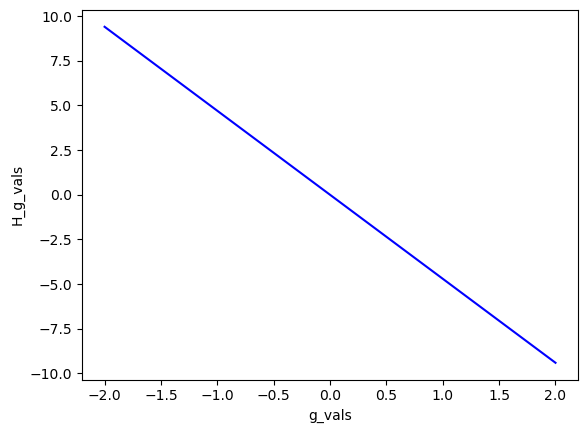

In [ ]:
sns.lineplot(
    data=df,
    x='g_vals',
    y='H_g_vals',
    color='blue'
)

In [ ]:
sns.lineplot(
    data=df,
    x='g_vals',
    y='H_ginv_vals',
    color='blue'
)

ValueError: Could not interpret value `H_ginv_vals` for `y`. An entry with this name does not appear in `data`.